# BrisT1D Blood Glucose Prediction Competition
Source: https://www.kaggle.com/competitions/brist1d/data

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
# get data
data_path = Path("~/Data/brist1d/")
train = pd.read_csv(data_path/ "train.csv", header = 0, index_col = 0)
test = pd.read_csv(data_path/ "test.csv", header = 0, index_col = 0)
sample_sub = pd.read_csv(data_path/ "sample_submission.csv")

# sample_sub.head()
# train.head()
train.shape, test.shape, sample_sub.shape


/var/folders/bs/gvm42h356mz5vjf9v118br000000gn/T/ipykernel_40368/878308419.py:3: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(data_path/ "train.csv", header = 0, index_col = 0)


((177024, 507), (3644, 506), (3644, 2))

In [11]:
# print the index of the unique features
feature_group_name = train.columns.str.extract(r"(^[a-zA-Z]+)")[0]  # get initial part of name
grouped_cols = train.columns.groupby(feature_group_name)
unique_initial_parts = {key: list(values) for key, values in grouped_cols.items()}  # get index values for each unique feature group
cols_indices = {key: [train.columns.get_loc(col) for col in values] for key, values in unique_initial_parts.items()}  # get column indices

# # print groups
# for key, values in unique_initial_parts.items():
#     print(f"{key}: {values}")
    
# print indices
for key, indices in cols_indices.items():
    print(f"{key}: {indices}")
    
# bg: blood glucose
# cals: total calories burnt in the last 5 mins
# carbs: total carbohydrate value consumed in grammes in the last 5 mins
# hr: mean heart rate per min
# steps: total steps walked in the last 5 min
# time: time of the day HH:MM:SS

activity: [434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505]
bg: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 506]
cals: [362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 42

In [12]:
# Only select the blood glucose values
# X = train.drop(columns=['bg+1:00'])
X = train.iloc[:,2:74]  # start with only blood glucose
y = train['bg+1:00'].values.reshape(-1, 1)
Z = test.iloc[:,2:74]

X.shape, y.shape, Z.shape

((177024, 72), (177024, 1), (3644, 72))

0
0


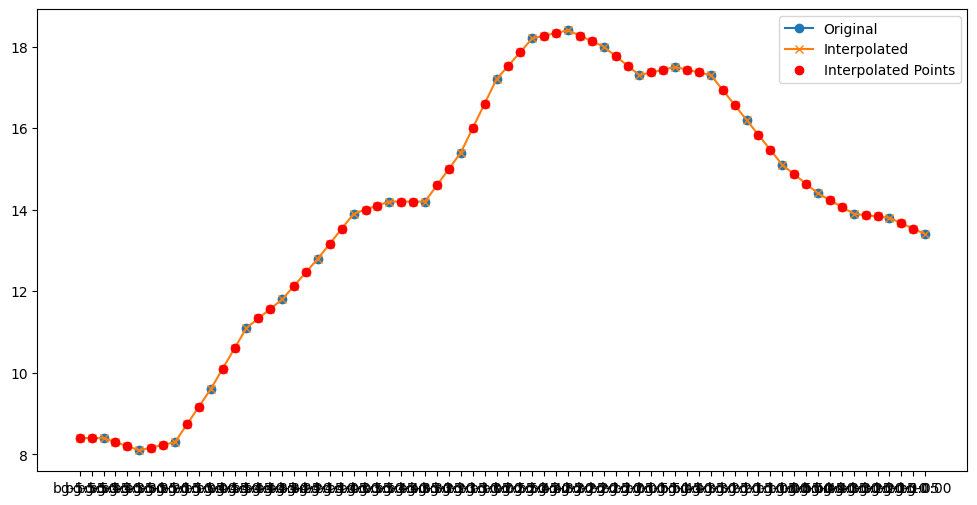

In [13]:
# Interpolate missing values using linear interpolation
X_interpolated = X.interpolate(method='linear', axis=1, limit_direction='both')
Z_interpolated = Z.interpolate(method='linear', axis=1, limit_direction='both')

# Check the result
print(X_interpolated.isna().sum().sum())  # Should be 0 if all NaNs are imputed
print(Z_interpolated.isna().sum().sum())  # Should be 0 if all NaNs are imputed

# Plot original and interpolated values for a specific patient
patient = "p01_4"
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(X.loc[patient], "o-", label="Original")
ax.plot(X_interpolated.loc[patient], "x-", label="Interpolated")

# Highlight interpolated points
interpolated_points = X.isna() & X_interpolated.notna()
interpolated_indices = interpolated_points.loc[patient][interpolated_points.loc[patient]].index
ax.plot(interpolated_indices, X_interpolated.loc[patient, interpolated_indices], "ro", label="Interpolated Points")

ax.legend()
plt.show()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# # Prepare data

# # Assuming reshaped_data and y are already defined
# X_train, X_test, y_train, y_test = train_test_split(X_interpolated, y, test_size=0.2, random_state=42)

# # Convert data to PyTorch tensors
# X3_train = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1).to(device)  # Add extra dimension, as LSTM expects 3D input
# y3_train = torch.tensor(y_train, dtype=torch.float32).to(device)
# X3_test = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1).to(device)  # Add extra dimension, as LSTM expects 3D input
# y3_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# # Ensure y3_train and y3_test are 2D tensors, because LSTM expects 2D output
# y3_train = y3_train.squeeze(1)
# y3_test = y3_test.squeeze(1)

# X3_train.shape, y3_train.shape, X3_test.shape, y3_test.shape

## Prepare Data
Prepare the data so that it can be used for PyTorch models. The models that will be tested, i.e. LSTM and LTSM + CNN,
expect the sequences in format (batch_size, sequence_length, input_size), so you don't need to create a separate DataLoader for
LSTM and LSTM + CNN. However, for Transformers, the data does need to be adjusted (see Transformers).

#### Data Dimensions
- reshaped_data has shape (samples, 72, feature_dim (72))

In [28]:
# Uses interpolated data
X2 = X_interpolated.values
Z2 = Z_interpolated.values

# Reshape for LSTM
samples, time_steps = X.shape[0], 72
reshaped_data = X2.reshape(samples, time_steps, -1)

# Standardize
scaler = StandardScaler()
reshaped_data = scaler.fit_transform(reshaped_data.reshape(-1, reshaped_data.shape[-1])).reshape(reshaped_data.shape)
print(f"Reshaped data shape: {reshaped_data.shape}")

# Split data
X3_train, X3_test, y3_train, y3_test = train_test_split(reshaped_data, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X3_train = torch.tensor(X3_train, dtype=torch.float32)
X3_test = torch.tensor(X3_test, dtype=torch.float32)
y3_train = torch.tensor(y3_train, dtype=torch.float32).view(-1, 1)
y3_test = torch.tensor(y3_test, dtype=torch.float32).view(-1, 1)
print(f"X3_train shape: {X3_train.shape}, y3_train shape: {y3_train.shape}, X3_test shape: {X3_test.shape}, y3_test shape: {y3_test.shape}")

# Dataloader
batch_size = 32         # Number of samples per batch
train_loader = DataLoader(TensorDataset(X3_train, y3_train), batch_size=batch_size, shuffle=True)
print(f"train_loader length: {len(train_loader)}")
val_loader = DataLoader(TensorDataset(X3_test, y3_test), batch_size=batch_size, shuffle=False)
print(f"val_loader length: {len(val_loader)}")

Reshaped data shape: (177024, 72, 1)
X3_train shape: torch.Size([141619, 72, 1]), y3_train shape: torch.Size([141619, 1]), X3_test shape: torch.Size([35405, 72, 1]), y3_test shape: torch.Size([35405, 1])
train_loader length: 4426
val_loader length: 1107


## LSTM with ReLU and Dropout

The discrepancy in RMSE between the PyTorch and Keras implementations could stem from several subtle but significant differences in how the models are constructed and trained in each framework. Here are the likely differences and how to address them:

- Activation Function: In Keras, you are explicitly setting activation='relu' in the LSTM layer. By default, PyTorch uses the tanh activation for the LSTM cells. Changing this activation function in PyTorch could help match Keras more closely.
- Dropout Layer: The Keras model includes a Dropout(0.2) layer after the LSTM, while the PyTorch model does not. Dropout can regularize the model, potentially lowering RMSE by reducing overfitting.
- Weight Initialization: PyTorch and Keras initialize weights differently by default, which can lead to differences in performance. You can set custom weight initializations in PyTorch to try to better match Keras' initialization.
- Training Process and Callbacks: Keras uses EarlyStopping and ModelCheckpoint callbacks, which improve the model’s performance by saving the best model and preventing overtraining. Adding similar early stopping in PyTorch will align the training process more closely with Keras.
- Normalization: The Keras code applies StandardScaler across all data before reshaping. Ensure that this same normalization is done in PyTorch with consistent preprocessing.


In [ ]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.relu = nn.ReLU()                           # ReLU activation
        self.dropout = nn.Dropout(dropout)              # Add dropout layer
        self.fc = nn.Linear(hidden_size, output_size)   # Fully connected layer

    def forward(self, x):
        out, _ = self.lstm(x)               # Pass through LSTM layer
        out = self.relu(out[:, -1, :])      # Apply ReLU to the last time step output
        out = self.dropout(out)             # Dropout before the final layer
        out = self.fc(out)                  # Pass through the fully connected layer
        return out

# Model parameters
input_size = reshaped_data.shape[2]         # Features per time step
hidden_size = 5                             # Number of neurons in hidden state
num_layers = 1                              # Number of LSTM layers
output_size = 1                             # Single output for future blood glucose level
dropout = 0.2                               # Dropout rate

# Create the model, and define the optimizer and loss function
model = LSTM(input_size, hidden_size, num_layers, output_size, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()                    # MSE for regression task

# Training loop with early stopping
num_epochs = 20
patience = 3 
best_val_loss = float('inf')  # Initialize with a large value
epochs_no_improve = 0         # Keep track of the number of epochs with no improvement
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Train the model
    model.train()                       
    train_loss = 0.0                    # Keep track of the training loss
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()           # Clear gradients
        output = model(x_batch)         # Forward pass
        loss = loss_fn(output, y_batch) # Compute the loss
        loss.backward()                 # Backward pass to compute gradients
        optimizer.step()                # Update weights
        train_loss += loss.item()       # Add the loss to the training set loss

    # Compute the average training loss
    train_loss /= len(train_loader) 
    train_losses.append(train_loss)

    # Validate the model
    model.eval()
    val_loss = 0.0                      # Keep track of the validation loss
    with torch.no_grad():               # No need to compute gradients
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)     # Forward pass
            loss = loss_fn(output, y_batch) # Compute the loss
            val_loss += loss.item()     # Add the loss to the validation set loss

    # Compute the average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

In [17]:
# Calculate RMSE
model.eval()
with torch.no_grad():
    y_pred = model(X3_test.to(device))
    y_true = y3_test.to(device)
    mse = loss_fn(y_pred, y_true).item()
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")

RMSE: 2.075631043408977


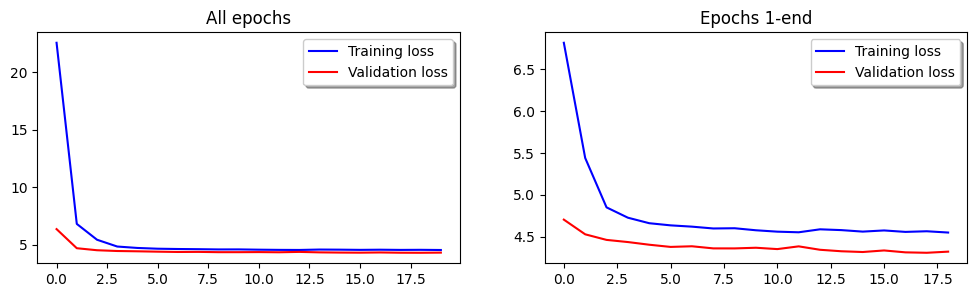

In [18]:
# Plotting the updated training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(train_losses, color='b', label="Training loss")
ax[0].plot(val_losses, color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("All epochs")
ax[1].plot(train_losses[1:], color='b', label="Training loss")
ax[1].plot(val_losses[1:], color='r', label="Validation loss")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Epochs 1-end")
plt.show()

## CNN-LSTM Hybrid for Time-Series Forecasting

The CNN-LSTM hybrid approach combines the spatial pattern extraction capabilities of CNNs with the temporal dependency modeling of LSTMs. Here, the CNN acts as a feature extractor before feeding the data into an LSTM layer.

In [19]:
class CNNLSTM(nn.Module):
    def __init__(self, input_size, cnn_out_channels, cnn_kernel_size, lstm_hidden_size, lstm_layers, output_size, dropout=0.2):
        super(CNNLSTM, self).__init__()
        # CNN layer
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=cnn_out_channels, kernel_size=cnn_kernel_size)
        self.relu = nn.ReLU()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(lstm_hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Shape (batch_size, input_size, sequence_length) for Conv1d
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Shape back to (batch_size, sequence_length, cnn_out_channels) for LSTM
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]  # Use last time step
        last_output = self.dropout(last_output)
        output = self.fc(last_output)
        return output

# Model parameters
input_size = reshaped_data.shape[2]         # Features per time step
cnn_out_channels = 32                       # Number of filters in the CNN layer
cnn_kernel_size = 3                         # Kernel size for Conv1d
lstm_hidden_size = 64                       # Hidden size of LSTM layer
lstm_layers = 1                             # Number of LSTM layers
output_size = 1                             # Single output for blood glucose prediction
dropout = 0.2

# Initialize the model, optimizer, and loss function
model = CNNLSTM(input_size, cnn_out_channels, cnn_kernel_size, lstm_hidden_size, lstm_layers, output_size, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training and validation loop with early stopping
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_cnn_lstm_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Load the best model
model.load_state_dict(torch.load('best_cnn_lstm_model.pth'))


Epoch 1/20, Training Loss: 5.3094, Validation Loss: 4.3136
Epoch 2/20, Training Loss: 4.4408, Validation Loss: 4.2571
Epoch 3/20, Training Loss: 4.4003, Validation Loss: 4.2606
Epoch 4/20, Training Loss: 4.3743, Validation Loss: 4.2510
Epoch 5/20, Training Loss: 4.3389, Validation Loss: 4.2559
Epoch 6/20, Training Loss: 4.2998, Validation Loss: 4.2338
Epoch 7/20, Training Loss: 4.2856, Validation Loss: 4.2298
Epoch 8/20, Training Loss: 4.2624, Validation Loss: 4.2160
Epoch 9/20, Training Loss: 4.2404, Validation Loss: 4.1779
Epoch 10/20, Training Loss: 4.2136, Validation Loss: 4.1805
Epoch 11/20, Training Loss: 4.1871, Validation Loss: 4.1639
Epoch 12/20, Training Loss: 4.1732, Validation Loss: 4.1737
Epoch 13/20, Training Loss: 4.1574, Validation Loss: 4.1723
Epoch 14/20, Training Loss: 4.1328, Validation Loss: 4.1620
Epoch 15/20, Training Loss: 4.1199, Validation Loss: 4.1371
Epoch 16/20, Training Loss: 4.1116, Validation Loss: 4.1352
Epoch 17/20, Training Loss: 4.0963, Validation Lo

<All keys matched successfully>

In [20]:
# Calculate RMSE
model.eval()
with torch.no_grad():
    y_pred = model(X3_test.to(device))
    y_true = y3_test.to(device)
    mse = loss_fn(y_pred, y_true).item()
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")

RMSE: 2.024198293343299


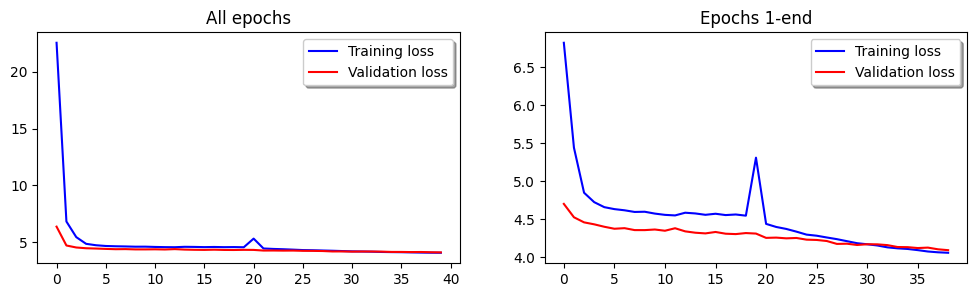

In [21]:
# Plotting the updated training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(train_losses, color='b', label="Training loss")
ax[0].plot(val_losses, color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("All epochs")
ax[1].plot(train_losses[1:], color='b', label="Training loss")
ax[1].plot(val_losses[1:], color='r', label="Validation loss")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Epochs 1-end")
plt.show()

## Transformer for Time-Series Forecasting

Transformers have been very effective for sequential data, including time series, thanks to their attention mechanisms. PyTorch includes a built-in nn.Transformer module that makes it easier to build a Transformer for forecasting tasks.


#### Data Preparation
The data shape used for the LSTMs need to be adjustes, because the Transformers expect an additional dimension for each time step.
Transformers typically require and input shape (batch_size, sequence_length, embedding_dim), where embedding_dim > 1.
This is because Transformers rely on self-attention mechanisms to learn relationships between elements in a sequence. With 
embedding_dim = 1, the model has very limited info at each time step, which limits its ability to effectively attend across 
the sequence. In practice, the embedding_dim is set to 32, 64 or higher, so that the model can represent more complex patterns
in the data. 


To account for this without changing the DataLoader previously used, you can either:
1. use an initial linear layer to expan reshaped_data from (batch_size, 72, 1) to (batch_size, 72, embedding_dim), or
2. Apply a 1D convolutional layer.

I will use (2.) as I want to create a Transformer model that is also able to handle more device features, although now
it is mainly used for blood glucose levels. 

In [29]:
import torch
import torch.nn as nn

class TransformerTimeSeries(nn.Module):
    def __init__(self, input_size, embedding_dim, num_heads, hidden_dim, num_layers, output_size, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        
        # Convolutional layer to expand the feature dimension to `embedding_dim`
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=embedding_dim, kernel_size=1)
        
        # Transformer Encoder
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        
        # Fully connected layer for the final output
        self.fc = nn.Linear(embedding_dim, output_size)

    def forward(self, x):
        # Reshape to (batch_size, input_size, sequence_length) for Conv1d
        x = x.permute(0, 2, 1)
        
        # Apply Conv1d for feature embedding
        x = self.conv1d(x)  # Now (batch_size, embedding_dim, sequence_length)
        
        # Reshape for transformer: (sequence_length, batch_size, embedding_dim)
        x = x.permute(2, 0, 1)
        
        # Pass through the Transformer Encoder
        x = self.transformer_encoder(x)
        
        # Reshape back: (batch_size, sequence_length, embedding_dim)
        x = x.permute(1, 0, 2)
        
        # Use the last time step's output
        x = x[:, -1, :]  # Shape: (batch_size, embedding_dim)
        
        # Final output layer
        output = self.fc(x)  # Shape: (batch_size, output_size)
        
        return output

# Model parameters
input_size = 1                      # Number of initial input features (e.g., 1 for blood glucose)
embedding_dim = 64                  # Embedding dimension for Transformer
num_heads = 2                       # Number of attention heads
hidden_dim = 128                    # Feedforward layer dimension in Transformer
num_layers = 3                      # Number of Transformer encoder layers
output_size = 1                     # Single output for blood glucose prediction
dropout = 0.1

# Initialize the model, optimizer, and loss function
model = TransformerTimeSeries(input_size, embedding_dim, num_heads, hidden_dim, num_layers, output_size, dropout=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


# Training and validation loop with early stopping
num_epochs = 20
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = loss_fn(output, y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_transformer_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Load the best model
model.load_state_dict(torch.load('best_transformer_model.pth'))


/Users/jantinebroek/miniconda3/envs/DL/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/20, Training Loss: 4.9710, Validation Loss: 4.6128
Epoch 2/20, Training Loss: 4.5732, Validation Loss: 4.5580
Epoch 3/20, Training Loss: 4.5298, Validation Loss: 4.5759
Epoch 4/20, Training Loss: 4.5065, Validation Loss: 4.5636
Early stopping


<All keys matched successfully>

In [30]:
# Calculate RMSE
model.eval()
with torch.no_grad():
    y_pred = model(X3_test.to(device))
    y_true = y3_test.to(device)
    mse = loss_fn(y_pred, y_true).item()
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse}")

RMSE: 2.1352968383911435


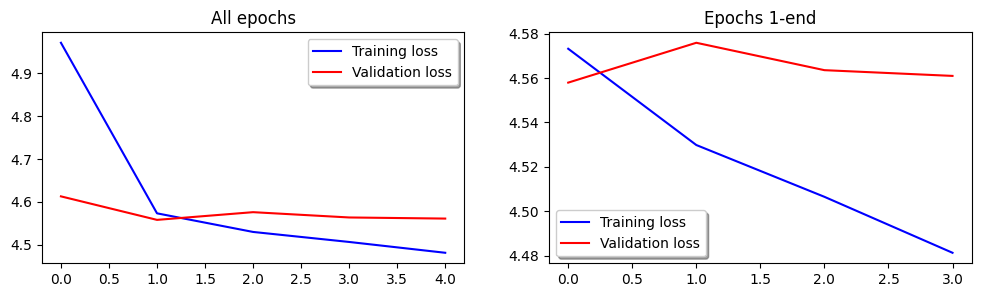

In [31]:
# Plotting the updated training and validation loss
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(train_losses, color='b', label="Training loss")
ax[0].plot(val_losses, color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title("All epochs")
ax[1].plot(train_losses[1:], color='b', label="Training loss")
ax[1].plot(val_losses[1:], color='r', label="Validation loss")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title("Epochs 1-end")
plt.show()